# AI in Chemical Engineering course report
## Lipophilicity (logP) prediction of compounds using mol2vec embeddings 

In [10]:
!pip install --quiet git+https://github.com/samoturk/mol2vec
!pip install --quiet rdkit-pypi
!pip install --quiet umap-learn
!pip install gensim==3.8.3


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     --------------------------------------- 24.2/24.2 MB 17.2 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.32
    Uninstalling Cython-0.29.32:
      Successfully uninstalled Cython-0.29.32
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.0
    Uninstalling gensim-4.3.0:
      Successfully uninstalled gensim-4.3.0


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\fiacac\\Anaconda3\\envs\\py38\\Lib\\site-packages\\~-nsim\\corpora\\_mmreader.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
# set a random seed for reproducibility
import sklearn
import numpy as np
np.random.seed(42)

## Data loading and pre-processing
This work uses the logP.csv file given during the course and the pre-trained mol2vec embeddings, which were downloaded from: https://www.kaggle.com/datasets/vladislavkisin/mlchem?select=model_300dim.pkl

In [2]:
import pandas as pd
from rdkit import Chem 

# load dataset
logP_data = pd.read_csv('logP.csv')

# drop group contributions, since we will only use the Smiles and the property (target)
logP_data = logP_data[['SMILES', 'Experimental']] 
logP_data = logP_data.astype(object)
logP_data.head()

,SMILES,Experimental
0,O=C(C)NCC(=O)NC(Cc1ccccc1)C(=O)N,-0.56
1,CN(C)C(=O)Oc1cccc(c1)N(C)C,1.93
2,O=S(=O)(C)OCCCNCCCOS(=O)(=O)C,-1.71
3,CNC12CCCCC1C(=C)c3ccccc23,3.79
4,OCC(F)CN1C=NC(=N1)N(=O)=O,-0.8


Here we need to pre-process and clean the dataset for the prediction task, so we ensure that there are no duplicates in the dataframe.
The dataset provided presented 179 duplicated compounds, therefore it was decided to keep the unique compounds and the average value of the duplicated logP property.

In [3]:
print('Total number of compounds in the dataset: ', len(logP_data))
print('Total unique compounds in the dataset: ', logP_data['SMILES'].nunique())
print('Duplicates: ', len(logP_data) - logP_data['SMILES'].nunique())
logP_data[logP_data.duplicated(subset='SMILES')==True]

# example of duplicates
print(logP_data[logP_data.SMILES == 'CNC(C)C(OC)c1ccccc1'])

# remove duplicates and keep the average property value
logP_data = logP_data.groupby('SMILES').mean().reset_index()

Total number of compounds in the dataset:  12193
Total unique compounds in the dataset:  12014
Duplicates:  179
                  SMILES Experimental
315  CNC(C)C(OC)c1ccccc1         1.87
957  CNC(C)C(OC)c1ccccc1         2.05


Extracting embeddings from Smiles through mol2vec

In [4]:
#Transforming Smiles to MOL
logP_data['mol'] = logP_data['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

# check if some moles were not found and drop them
print(logP_data[logP_data.mol.isna()])
logP_data = logP_data.dropna()
print()
print('Total unique compounds in the dataset after pre-processing: ', len(logP_data))

[16:20:40] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
[16:20:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:20:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:20:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:20:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:20:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 11 12 13 14 15 16
[16:20:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:20:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:20:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18


                                SMILES  Experimental   mol
10646           O=c1c2ccccc2cc3ccccc13          3.66  None
10657                 O=c1ccnc2ccccc12          0.58  None
10658                 O=c1cnnc2ccccc12          0.82  None
10662       O=c1nc(nc2ccccc12)c3ccccc3          2.53  None
10663                 O=c1ncnc2ccccc12          0.77  None
10664       O=c1nnc(c2ccccc2)c3ccccc13          2.48  None
10665                 O=c1nncc2ccccc12          0.75  None
10666                 O=c1nnnc2ccccc12          0.83  None
11928  c1ccc2c(c1)c3ccc4cccc5ccc2c3c45          5.78  None

Total unique compounds in the dataset after pre-processing:  12005


In [5]:
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

model_mol2vec = word2vec.Word2Vec.load('model_300dim.pkl')

Here we construct the sentences using mol2vec.
The code on how to extract the sectences is inspired by: https://www.kaggle.com/code/vladislavkisin/tutorial-ml-in-chemistry-research-rdkit-mol2vec/notebook

In [6]:
# constructing sentences
logP_data['sentence'] = logP_data.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

# extracting embeddings to a numpy.array
# note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
# logP_data['mol2vec'] = [DfVec(x) for x in sentences2vec(logP_data['sentence'], model_mol2vec, unseen='UNK')]
logP_data['mol2vec'] = [DfVec(x) for x in sentences2vec(logP_data['sentence'], model_mol2vec, unseen='UNK')]
X = np.array([x.vec for x in logP_data['mol2vec']])
y = logP_data['Experimental'].values

print('Shape of the data: ', X.shape)

Shape of the data:  (12005, 300)


In [7]:
logP_data

,SMILES,Experimental,mol,sentence,mol2vec
0,BrC,1.19,<rdkit.Chem.rdchem.Mol object at 0x0000014CB57...,"(3612926680, 318524446, 2246728737)","(300,) dimensional vector"
1,BrC(Br)(Br)Br,3.42,<rdkit.Chem.rdchem.Mol object at 0x0000014CB57...,"(3612926680, 325281617, 2245277810, 3901192881...","(300,) dimensional vector"
2,BrC(Br)Br,2.40,<rdkit.Chem.rdchem.Mol object at 0x0000014CB57...,"(3612926680, 325259454, 2245273601, 1029714706...","(300,) dimensional vector"
3,BrC(C)C,2.14,<rdkit.Chem.rdchem.Mol object at 0x0000014CB57...,"(3612926680, 325259454, 2245273601, 3473431882...","(300,) dimensional vector"
4,BrC(F)(F)F,1.86,<rdkit.Chem.rdchem.Mol object at 0x0000014CB57...,"(3612926680, 325281617, 2245277810, 2846563933...","(300,) dimensional vector"
...,...,...,...,...,...
12009,n1cnc2nccnc2c1,-0.58,<rdkit.Chem.rdchem.Mol object at 0x0000014CB59...,"(2041434490, 3118255683, 3218693969, 725322217...","(300,) dimensional vector"
12010,n1cnccc1,-0.40,<rdkit.Chem.rdchem.Mol object at 0x0000014CB59...,"(2041434490, 3118255683, 3218693969, 725322217...","(300,) dimensional vector"
12011,n1cncnc1,0.12,<rdkit.Chem.rdchem.Mol object at 0x0000014CB59...,"(2041434490, 3118255683, 3218693969, 725322217...","(300,) dimensional vector"
12012,n1ncc2ccccc2c1,0.57,<rdkit.Chem.rdchem.Mol object at 0x0000014CB59...,"(2041434490, 3457964313, 2041434490, 345796431...","(300,) dimensional vector"


Extra: here we save the compounds and their respective vectors in two .tsv files. The reason for this is that the files can be uploaded here: https://projector.tensorflow.org/ and we can visualize the molecular embeddings in 3D and inspect the compounds in lower dimensional space. The program allows for dimensionality reduction through three methods (PCA; T-SNE and UMAP) plus a custom method.

In [ ]:
logP_data[['SMILES']].to_csv('smiles3.tsv', index=False, sep='\t')
pd.DataFrame(X).to_csv('vectors3.tsv', index=False, sep='\t')

### Dimensionality reduction

Here we define multiple methods that can be used for visualizing the compounds in lower dimensional space. Here we use a combination of PCA and T-SNE as suggested in https://github.com/samoturk/mol2vec/blob/master/examples/01%20-%20Basic%20concepts%20of%20Mol2vec.ipynb. 

In [8]:
logP_data2 = pd.read_csv('smiles3.tsv', sep='\t')
X = pd.read_csv('vectors3.tsv', sep='\t')
y = logP_data['Experimental'].values

In [9]:
print(len(X), len(y))

12005 12005


In [10]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import umap.umap_ as umap

# select preferred method
def dimensionality_reduction(method):
    if method == 'PCA':
        pca = PCA(n_components=2, svd_solver='full')
        X_transformed = pca.fit_transform(X)
    elif method == 'TSNE':
        X_transformed = TSNE(n_components=2, learning_rate='auto',
                          init='random').fit_transform(X)
    elif method == 'UMAP':
        umap_2d = umap.UMAP(random_state=0)
        X_transformed = umap_2d.fit_transform(X)

    elif method == 'PCA-TSNE':
        pca_model = PCA(n_components=30)
        tsne_model = TSNE(n_components=2, perplexity=10, n_iter=1000, metric = 'cosine')
        X_transformed = tsne_model.fit_transform(pca_model.fit_transform(X))
    return X_transformed

method = 'PCA-TSNE'
X_transformed = dimensionality_reduction(method)

C:\Users\fiacac\Anaconda3\envs\py38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\fiacac\Anaconda3\envs\py38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\fiacac\Anaconda3\envs\py38\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


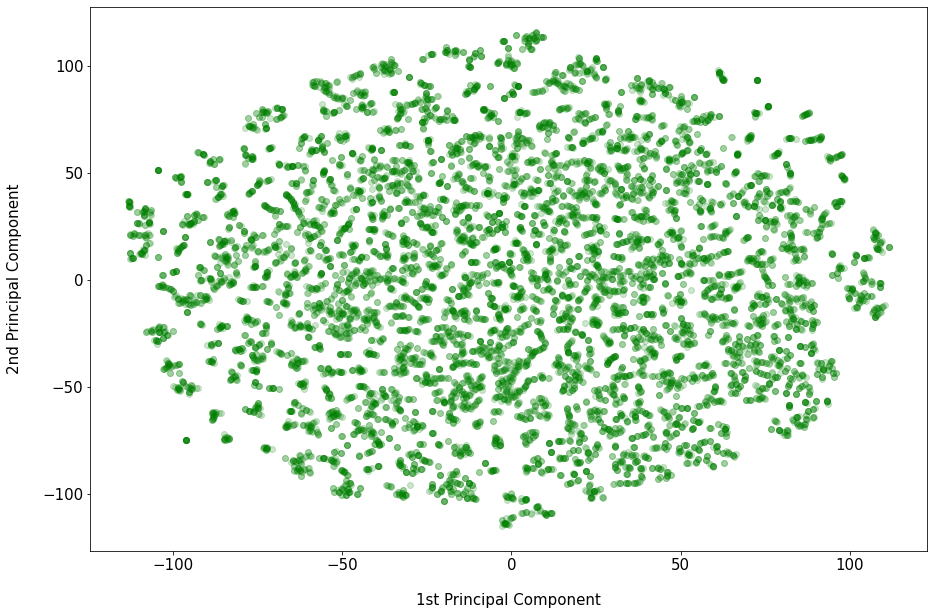

In [24]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,10))
plt.plot(X_transformed[:,0], X_transformed[:,1], 'o', c='green', alpha=0.2)
#plt.title('PCA and T-SNE Results: mol2vec', pad=20)
plt.xlabel("1st Principal Component", labelpad=20)
plt.ylabel("2nd Principal Component", labelpad=20)
# plt.tick_params(axis='both', which='major', pad=50)
plt.savefig('pca.jpg')

In [ ]:
# use plotly for more interactive plots
# fig = px.scatter(
#     X_transformed, x=0, y=1,
#     #color=digits.target.astype(str), labels={'color': 'digit'})
# fig.show()

## Lipophilicity prediction

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# define evaluation function
def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    r2 = sklearn.metrics.r2_score(y_test, prediction)
    
    plt.figure(figsize=(10, 7))
    plt.plot(prediction[:300], "red", label="Predictions", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="Observations", linewidth=1.0)
    plt.legend()
    plt.show()
    x = np.linspace(y_test.min(),y_test.max(), 100)
    y = x
    #m, b = np.polyfit(y_test, prediction, 1)
    #plt.plot(y_test, m*y_test + b, '--', color='red', label='regression line')
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, prediction, alpha=0.5, label='logP predictions')
    plt.plot(x, y, '--', color='black', label='regression line')
    #plt.grid()
    plt.legend()
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.ylabel('logP')
    #plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.title("Parity plot of the observed and predicted target values")
    plt.show()
    
    print('MAE score:', round(mae, 4))
    print('MSE score:', round(mse, 4))
    print('RMSE score:', round(rmse, 4))
    print('R2 score:', round(r2, 4))

In [21]:
# split dataset into train, validation, test sets
from sklearn.model_selection import train_test_split

X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=.2)#, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_t, y_t, test_size=.5)#, random_state=1)

print('Train set size: ', len(X_train), len(y_train))
print('Validation set size: ', len(X_val), len(y_val))
print('Test set size: ', len(X_test), len(y_test))

Train set size:  9604 9604
Validation set size:  1200 1200
Test set size:  1201 1201


## Training machine learning models

Here we train four models on the regression task.
Hyperparameter tuning is done on the validation set through manual grid search of selected parameters.
The models used in this section are:
- Linear regression (selected as baseline)
- Support Vector Machine for regression (SVR)
- XGBoost
- Ensamble (voting algorithm) of the previous three algorithms.

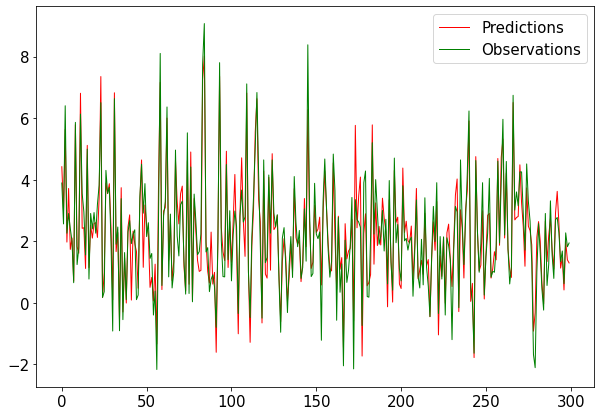

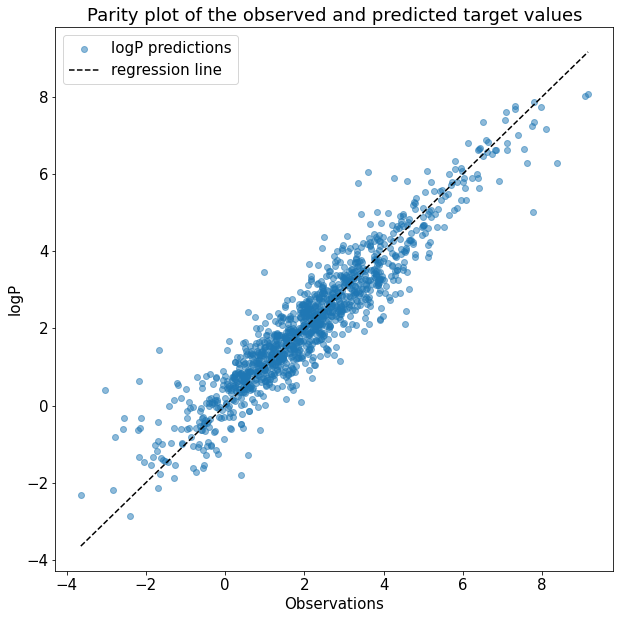

MAE score: 0.4815
MSE score: 0.4103
RMSE score: 0.6405
R2 score: 0.8764


In [25]:
import sklearn
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(X_train, y_train)
evaluation(lin_reg, X_val, y_val)

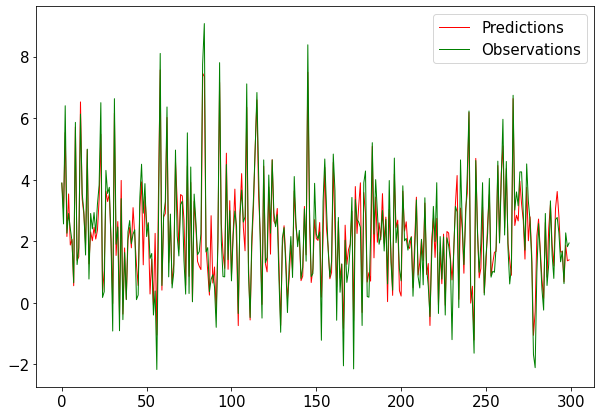

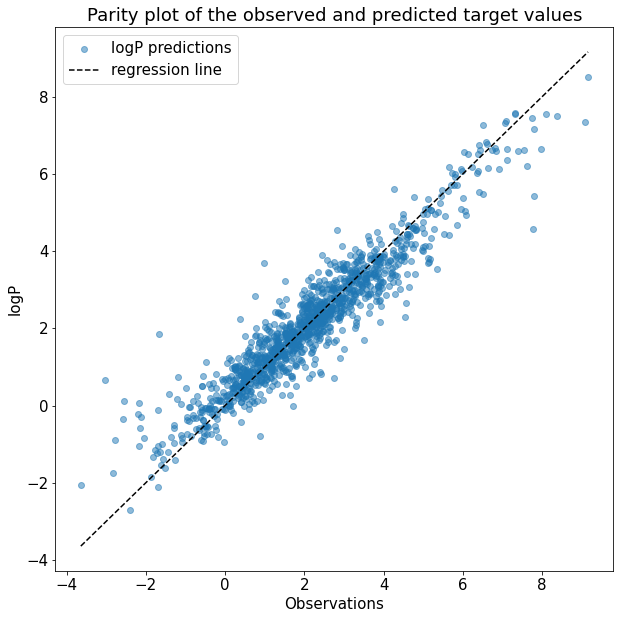

MAE score: 0.4421
MSE score: 0.3778
RMSE score: 0.6147
R2 score: 0.8861


In [26]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf').fit(X_train, y_train)
evaluation(svr_rbf, X_val, y_val)

[16:25:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




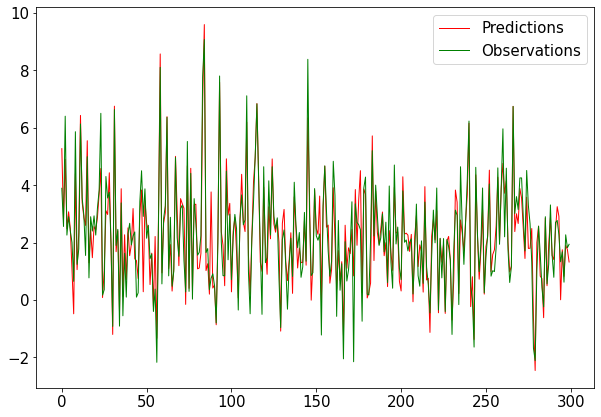

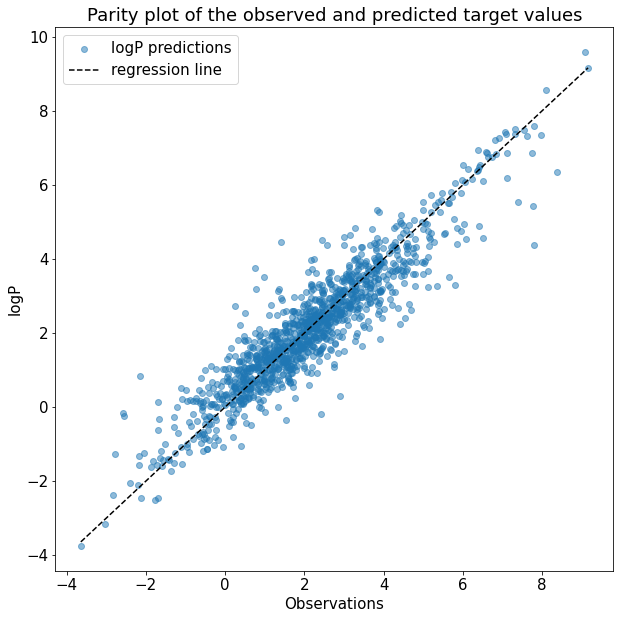

MAE score: 0.5154
MSE score: 0.4897
RMSE score: 0.6998
R2 score: 0.8524


In [27]:
import xgboost
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=1000, max_depth=6, eta=0.3, subsample=0.7, colsample_bytree=0.8, reg='squarederror').fit(X_train, y_train)
evaluation(xgb, X_val, y_val)

[16:26:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




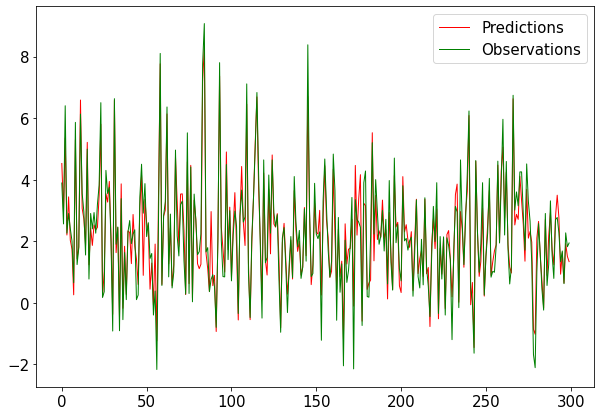

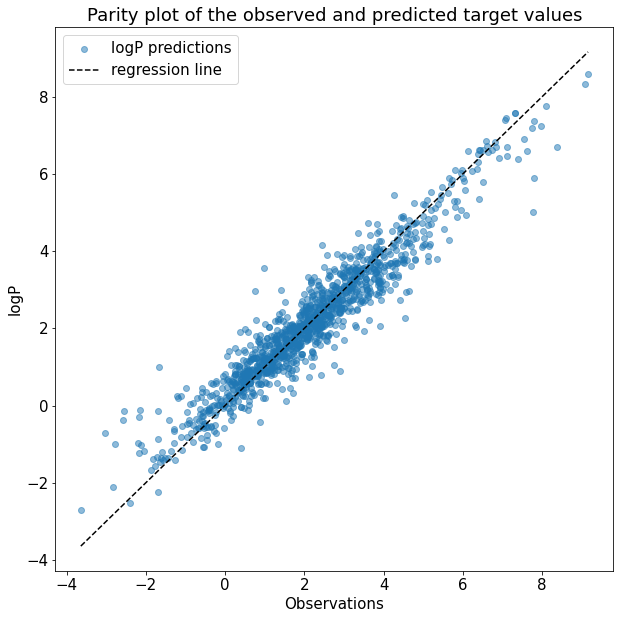

MAE score: 0.4142
MSE score: 0.3208
RMSE score: 0.5664
R2 score: 0.9033


In [28]:
from sklearn.ensemble import VotingRegressor

ereg = VotingRegressor(estimators=[('lr', lin_reg), ('svr', svr_rbf), ('xgb', xgb)])
ereg = ereg.fit(X_train, y_train)
evaluation(ereg, X_val, y_val)

## Evaluation: Calculating models performance on unseen test set

Calculating the performance on an unseen test set is very important to prevent having a biased model.

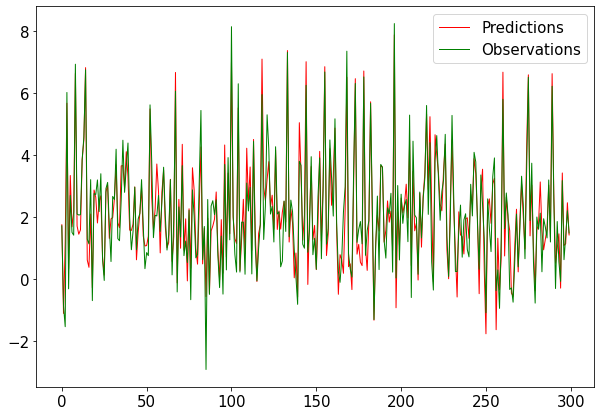

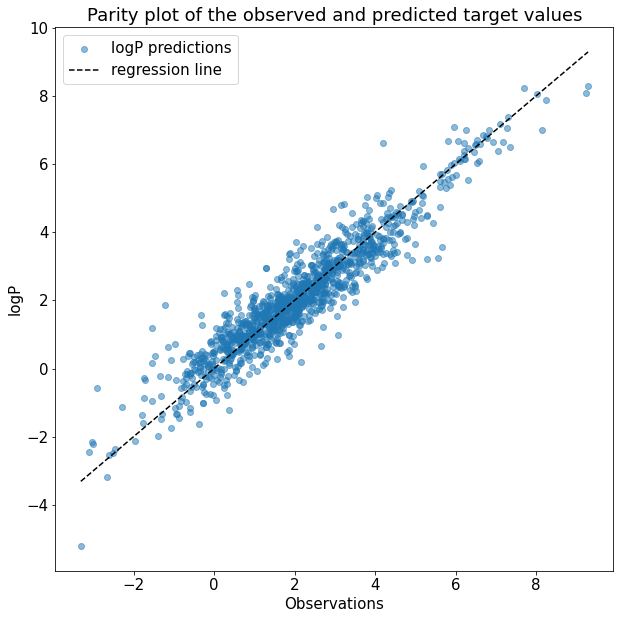

MAE score: 0.4572
MSE score: 0.3741
RMSE score: 0.6116
R2 score: 0.8782


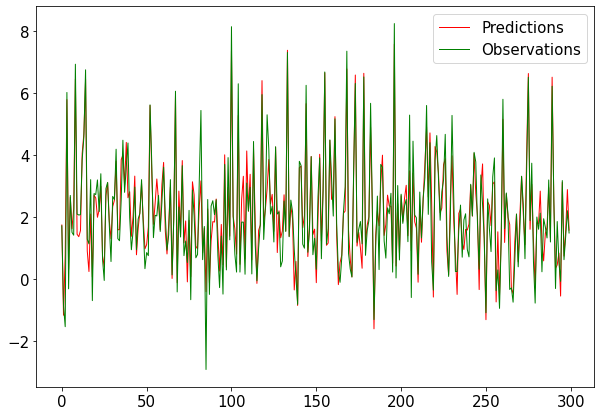

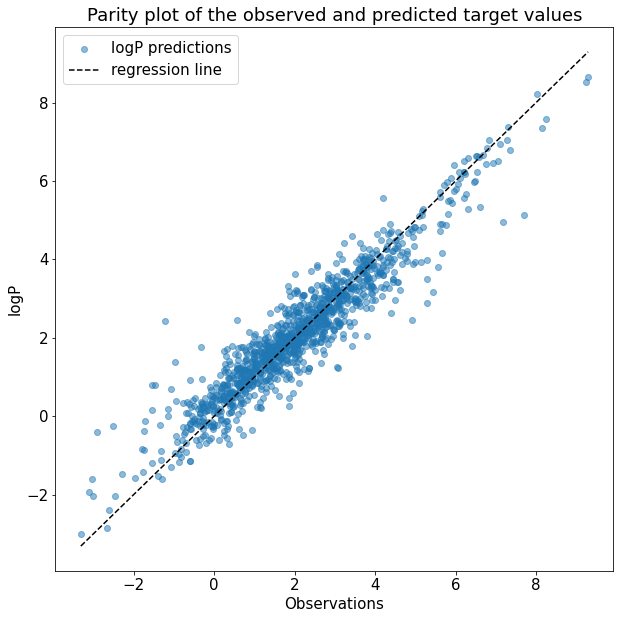

MAE score: 0.428
MSE score: 0.3484
RMSE score: 0.5902
R2 score: 0.8866


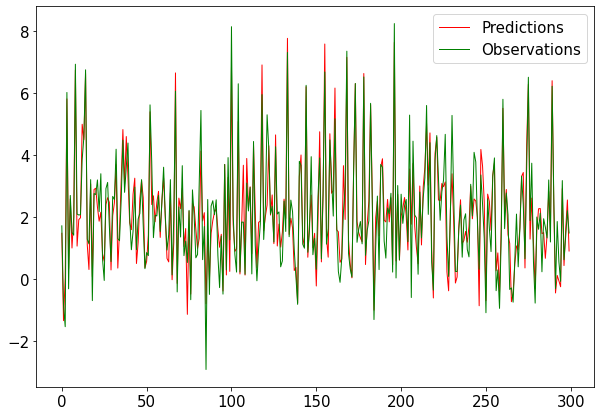

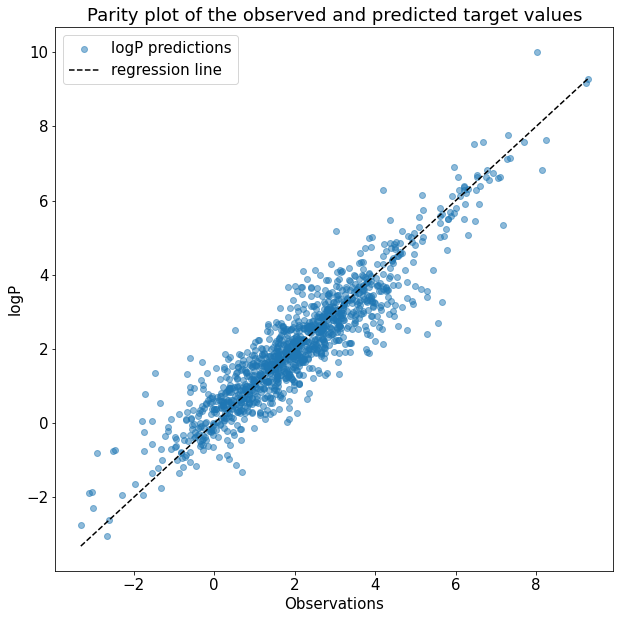

MAE score: 0.5079
MSE score: 0.4689
RMSE score: 0.6848
R2 score: 0.8473


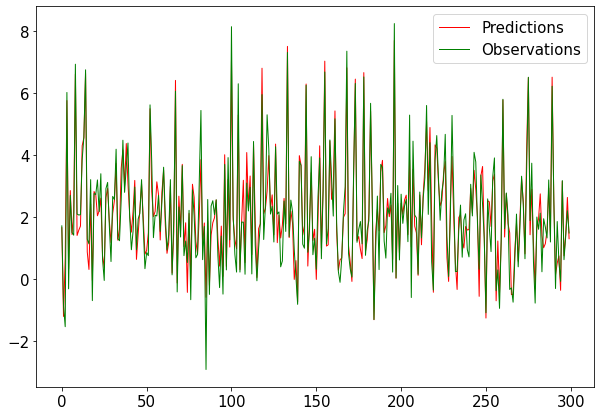

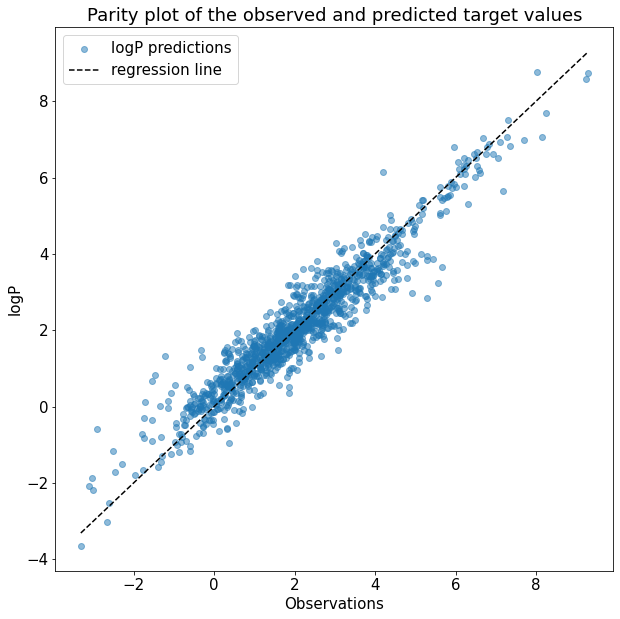

MAE score: 0.4029
MSE score: 0.2966
RMSE score: 0.5446
R2 score: 0.9034


In [29]:
# final models
evaluation(lin_reg, X_test, y_test)
evaluation(svr_rbf, X_test, y_test)
evaluation(xgb, X_test, y_test)
evaluation(ereg, X_test, y_test)

In [30]:
# remove later
ereg2 = ereg.fit(X, y)
evaluation(ereg2, X, y)

KeyboardInterrupt: 

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(max_iter=500).fit(X_train, y_train) #random_state=1, 
evaluation(mlp, X_test, y_test)

## Cross-validation

In [ ]:
def evaluation_cross_val(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    r2 = sklearn.metrics.r2_score(y_test, prediction)
    return mae, mse, rmse, r2

In [ ]:
# tot_lr_r2 = []
# tot_svr_r2 = []
# tot_xgb_r2 = []
# tot_ens_r2 = []

# for i in range(5):
#     X1, X2, y1, y2 = train_test_split(X, y, test_size=.2, random_state=i)
#     lr_cv = LinearRegression().fit(X1, y1)
#     svr_cv = SVR(kernel='rbf').fit(X1, y1)
#     xgb_cv = XGBRegressor(n_estimators=1000, max_depth=6, eta=0.3, subsample=0.7, colsample_bytree=0.8, reg='squarederror').fit(X1, y1)
#     ens = VotingRegressor(estimators=[('lr', lr_cv), ('svr', svr_cv), ('xgb', xgb_cv)]).fit(X1, y1)

#     lr_mae, lr_mse, lr_rmse, lr_r2 = evaluation_cross_val(lr_cv, X2, y2)
#     svr_mae, svr_mse, svr_rmse, svr_r2 = evaluation_cross_val(svr_cv, X2, y2)
#     xgb_mae, xgb_mse, xgb_rmse, xgb_r2 = evaluation_cross_val(xgb_cv, X2, y2)
#     ens_mae, ens_mse, ens_rmse, ens_r2 = evaluation_cross_val(ens, X2, y2)

#     tot_lr_r2.append(lr_r2)
#     tot_svr_r2.append(svr_r2)
#     tot_xgb_r2.append(xgb_r2)
#     tot_ens_r2.append(ens_r2)

# print(np.mean(tot_lr_r2), tot_lr_r2)
# print(np.mean(tot_svr_r2), tot_svr_r2)
# print(np.mean(tot_xgb_r2), tot_xgb_r2)
# print(np.mean(tot_ens_r2), tot_ens_r2)

## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import *

## adding this 
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

data = X_train.reshape((1, len(X_train), 300))
target = y_train.reshape((1, len(X_train)))
print(data.shape)
data_val = X_val.reshape((1, len(X_val), 300))
target_val = y_val.reshape((1, len(X_val)))

X_lstm = np.concatenate((X_train, X_val), axis=0)
y_lstm = np.concatenate((y_train, y_val), axis=0)
print(X_lstm.shape, y_lstm.shape)
data2 = X_lstm.reshape((1, len(X_lstm), 300))
target2 = y_lstm.reshape((1, len(X_lstm)))
#data2 = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))
#target2 = y_lstm.reshape((len(X_lstm), 1))
print(data2.shape)
print(target2.shape)


In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
model = tf.keras.Sequential([
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(1)])

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=0,
    decay_rate=0.9)
#optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.001))

history = model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=1, 
          validation_data=(X_val, y_val))
#validation_split=0.1)
model.summary()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
model.evaluate(X_test, y_test)
pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# define evaluation function
def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    r2 = sklearn.metrics.r2_score(y_test, prediction)
    
    plt.figure(figsize=(10, 7))
    plt.plot(prediction[:300], "red", label="Predictions", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="Observations", linewidth=1.0)
    plt.legend()
    plt.show()
    x = np.linspace(y_test.min(),y_test.max(), 100)
    y = x
    #m, b = np.polyfit(y_test, prediction, 1)
    #plt.plot(y_test, m*y_test + b, '--', color='red', label='regression line')
    plt.figure(figsize=(15, 10))
    plt.scatter(y_test, prediction, alpha=0.5, label='logP predictions')
    plt.plot(x, y, '--', color='black', label='x = y')
    #plt.grid()
    plt.legend()
    plt.xlabel('Observed values [logP]')
    plt.ylabel('Predicted values [logP]')
    # plt.ylabel('logP')
    #plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    #plt.title("Parity plot of the observed and predicted target values")
    plt.savefig('parityplot.jpg')
    plt.show()
    
    
    print('MAE score:', round(mae, 4))
    print('MSE score:', round(mse, 4))
    print('RMSE score:', round(rmse, 4))
    print('R2 score:', round(r2, 4))

In [ ]:
evaluation(model, X_test, y_test)

In [ ]:
lstm = keras.Sequential()
lstm.add(
    layers.Bidirectional(layers.LSTM(300, return_sequences=True), input_shape=(len(X_train), 300))
)

#lstm.add(layers.Bidirectional(layers.LSTM(200)))
#lstm.add(layers.Bidirectional(layers.LSTM(200)))

lstm.add(layers.Dense(1))

lstm.summary()

In [ ]:
lstm.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.001))
lstm.fit(data, target, epochs=500, batch_size=32, verbose=1)#validation_data=(data_val, target_val))
lstm.summary()

In [ ]:
z = np.zeros((8403, 300))
X_test2 = np.concatenate((X_test, z), axis=0)
z2 = np.zeros(8403)
y_test2 = np.concatenate((y_test, z2), axis=0)

data_t = X_test2.reshape((1, len(X_test2), 300))
target_t = y_test2.reshape((1, len(X_test2)))

In [ ]:
lstm.evaluate(data_t, target_t)
pred = lstm.predict(data_t)

In [ ]:
def eval_lstm(y_test, prediction):
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    r2 = sklearn.metrics.r2_score(y_test, prediction)

    plt.figure(figsize=(10, 7))
    plt.plot(prediction[:300], "red", label="Predictions", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="Observations", linewidth=1.0)
    plt.legend()
    plt.show()
    x = np.linspace(y_test.min(),y_test.max(), 100)
    y = x
    #m, b = np.polyfit(y_test, prediction, 1)
    #plt.plot(y_test, m*y_test + b, '--', color='red', label='regression line')
    plt.figure(figsize=(10, 7))
    plt.scatter(y_test, prediction, alpha=0.5)
    plt.plot(x, y, '--', color='black', label='linear')
    #plt.grid()
    # plt.legend()
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    # plt.ylabel('logP')
    # plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()

    print('MAE score:', round(mae, 4))
    print('MSE score:', round(mse, 4))
    print('RMSE score:', round(rmse, 4))
    print('R2 score:', round(r2, 4))

In [ ]:
eval_lstm(y_test, pred.flatten()[:1201])